In [1]:
import sys
sys.path.append("../")
import numpy as np
import phate
import graphtools as gt
import numpy as np
import pygsp
from src.mds import embed_MDS
import scprep
from scipy.spatial.distance import jensenshannon
from src.embedding import EmbJSD, EmbHeatGeo, EmbHeatPHATE, EmbCTD, EmbGraphMMD, EmbMarHeatGeo, CraneEmb, new_HeatGeo
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import umap

/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-26 18:08:44.456557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 18:08:46.075461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 18:08:46.075590: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you

In [2]:
pbmc = sc.datasets.pbmc3k_processed()
data = pbmc.X
labels = pbmc.obs["louvain"]
knn=5
anisotropy=0
decay=40
tau_min=0.1
tau_max=10
labels = labels.replace(to_replace=['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
value=[0,1,2,3,4,5,6,7]
)

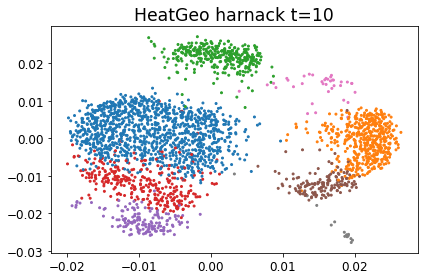

In [4]:
emb_op = new_HeatGeo(knn=knn, anisotropy=anisotropy, tau=10, harnack=True)
emb_op.scatterplot(data, labels=labels, title="HeatGeo harnack t=10")

In [10]:
a=np.array([[1,2],[3,4]])
a = np.expand_dims(a, axis=-1)
len(a.shape)

3

In [12]:
a[:,:,0]

array([[1, 2],
       [3, 4]])

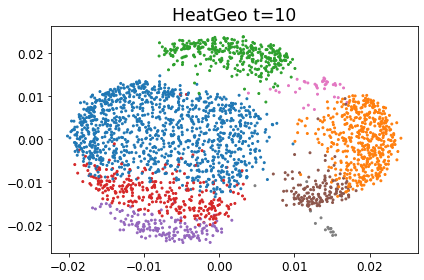

In [9]:
emb_op = new_HeatGeo(knn=knn, anisotropy=anisotropy, tau=10)
emb_op.scatterplot(data, labels=labels, title="HeatGeo t=10")

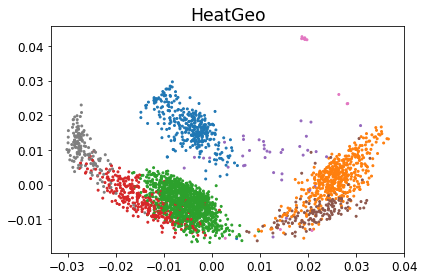

In [40]:
emb_op = new_HeatGeo(knn=knn, anisotropy=anisotropy, decay=decay, tau_min=0.005, tau_max=50, n_tau=5,tau=50, filter_method="mar", order=5, denoising=True, n_ref=300)
emb_op.scatterplot(data, labels=labels, title="HeatGeo")


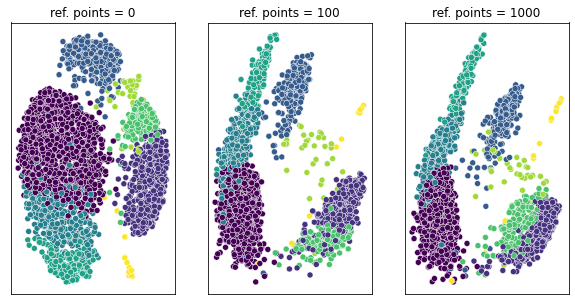

In [58]:
# Create one figure for different embeddings depending on the choice of n_ref 
fig, axs = plt.subplots(1, 3, figsize=(10, 10/2))
for i, n_ref in enumerate([0, 100, 1000]):
    denoising = False if n_ref == 0 else True
    emb_op = new_HeatGeo(knn=knn, anisotropy=anisotropy, decay=decay, tau_min=0.005, tau_max=50, n_tau=1,tau=0.5, filter_method="euler", order=10, denoising=denoising, n_ref=n_ref)
    emb = emb_op.fit_transform(data)
    sns.scatterplot(x=emb[:,0],y=emb[:,1], ax=axs[i], c=labels).set(title="ref. points = {}".format(n_ref))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
#fig.suptitle("Selective denoising", size=16, y=1.05)
fig.savefig("pbmc_selective_denoising.png", dpi=400,  bbox_inches='tight')


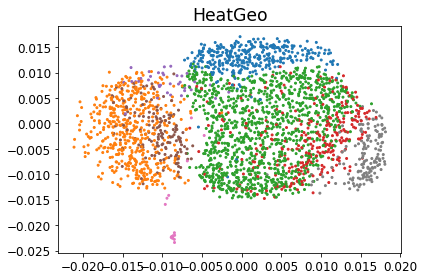

In [27]:
emb_op = new_HeatGeo(knn=knn, anisotropy=anisotropy, decay=decay, tau_min=tau_min, tau_max=tau_max, n_tau=1,tau=50, filter_method="mar", order=5)
emb_op.scatterplot(data, labels=labels, title="HeatGeo")


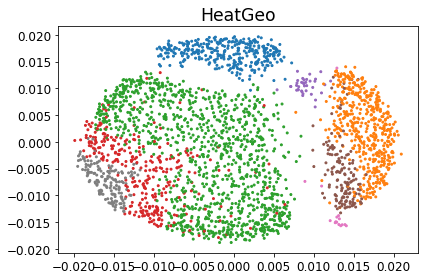

In [28]:
emb_op = new_HeatGeo(knn=knn, anisotropy=anisotropy, decay=decay, tau_min=tau_min, tau_max=tau_max, n_tau=1,tau=50, filter_method="euler", order=20)
emb_op.scatterplot(data, labels=labels, title="HeatGeo")

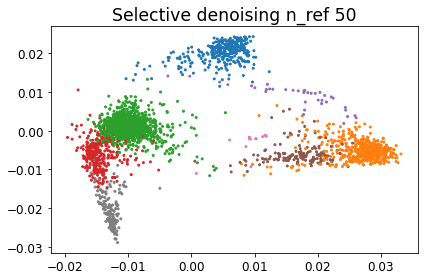

In [18]:
# Selective denoising
denoising=True
n_ref=50
heat_geo_op = new_HeatGeo(knn=knn, anisotropy=1, decay=decay, tau=5, filter_method="mar", n_tau=1, denoising=denoising, n_ref=n_ref, n_svd=30)
heat_geo_op.scatterplot(data, labels=labels, title=f"Selective denoising n_ref {n_ref}")

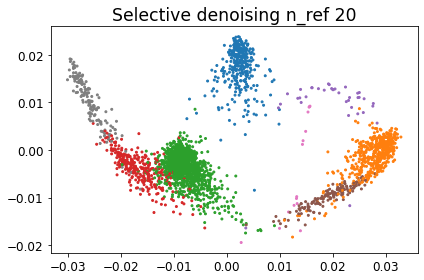

In [16]:
# Selective denoising
denoising=True
n_ref=20
heat_geo_op = new_HeatGeo(knn=knn, anisotropy=1, decay=decay, tau=5, filter_method="mar", n_tau=1, denoising=denoising, n_ref=n_ref, n_svd=30)
heat_geo_op.scatterplot(data, labels=labels, title=f"Selective denoising n_ref {n_ref}")

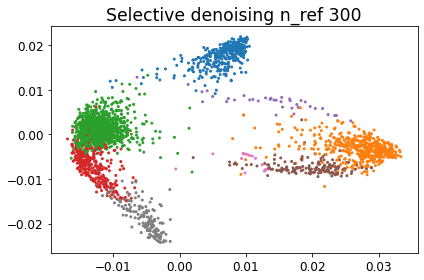

In [19]:
# Selective denoising
denoising=True
n_ref=300
heat_geo_op = new_HeatGeo(knn=knn, anisotropy=1, decay=decay, tau=5, filter_method="mar", n_tau=1, denoising=denoising, n_ref=n_ref, n_svd=30)
heat_geo_op.scatterplot(data, labels=labels, title=f"Selective denoising n_ref {n_ref}")

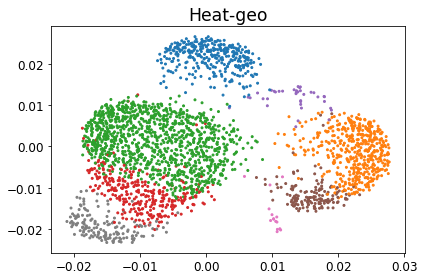

In [20]:
# Selective denoising
denoising=False
n_ref=20
heat_geo_op = new_HeatGeo(knn=knn, anisotropy=1, decay=decay, tau=5, filter_method="mar", n_tau=1, denoising=denoising, n_ref=n_ref, n_svd=30)
heat_geo_op.scatterplot(data, labels=labels, title="Heat-geo")

In [3]:
emb_umap = pbmc.obsm["X_umap"]
emb_tsne = pbmc.obsm["X_tsne"]
phate_heat = EmbHeatGeo(knn=knn, anisotropy=anisotropy, decay=decay)
phate_op = phate.PHATE(knn=knn, verbose=False,anisotropy=anisotropy, decay=decay)
emb_heat = phate_heat.fit_transform(data,tau_min=0.1, tau_max=0.1, n_tau=1)
phate_heat_10 = EmbHeatGeo(knn=knn, anisotropy=anisotropy, decay=decay)
emb_heat_10 = phate_heat.fit_transform(data,tau_min=100, tau_max=100, n_tau=1)
emb_phate = phate_op.fit_transform(data)
multi_geo = EmbHeatGeo(knn=knn, anisotropy=anisotropy, decay=decay)
emb_multi = multi_geo.fit_transform(data, tau_min=tau_min, tau_max=tau_max, n_tau=10)

In [4]:
labels = labels.replace(to_replace=['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
value=[0,1,2,3,4,5,6,7]
)


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other argume

[Text(0.5, 1.0, 'Multi Heat-Geo')]

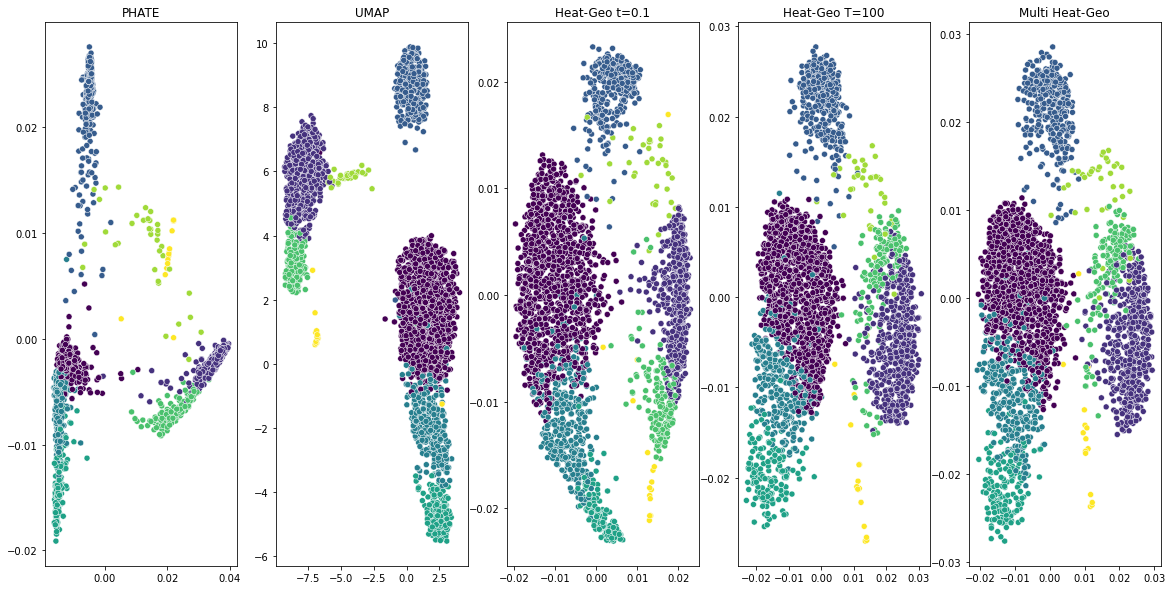

In [29]:
fig, axes = plt.subplots(1,5,figsize=(20,10))
sns.scatterplot(emb_phate[:,0],emb_phate[:,1], ax=axes[0], c=labels).set(title="PHATE")
sns.scatterplot(emb_umap[:,0],emb_umap[:,1], ax=axes[1], c=labels).set(title="UMAP")
sns.scatterplot(emb_heat[:,0],emb_heat[:,1], ax=axes[2], c=labels).set(title="Heat-Geo t=0.1")
sns.scatterplot(emb_heat_10[:,0],emb_heat_10[:,1], ax=axes[3], c=labels).set(title="Heat-Geo T=100")
sns.scatterplot(emb_multi[:,0],emb_multi[:,1], ax=axes[4], c=labels).set(title="Multi Heat-Geo")

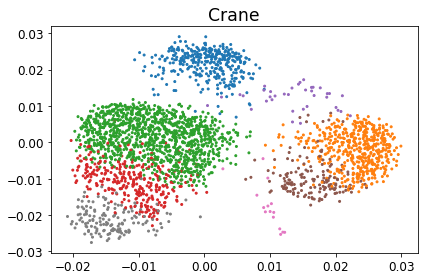

In [4]:
emb_crane = CraneEmb(knn=knn)
emb_crane.scatterplot(data,labels,title="Crane", t=0.05, K=30)

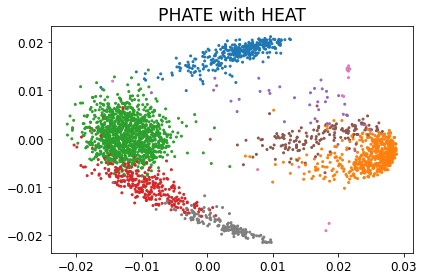

In [3]:
emb_phate_heat = EmbHeatPHATE(knn=knn)
emb_phate_heat.scatterplot(data,labels,title="PHATE with HEAT", tau=0.5)

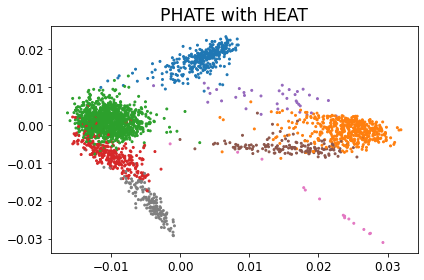

In [4]:
emb_phate_heat = EmbHeatPHATE(knn=knn)
emb_phate_heat.scatterplot(data,labels,title="PHATE with HEAT", tau=10)

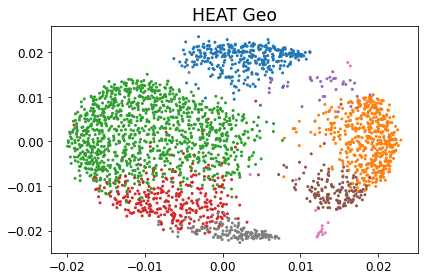

In [5]:
emb_op = EmbHeatGeo(knn=knn)
emb_op.scatterplot(data,labels,title="HEAT Geo", tau=0.5)

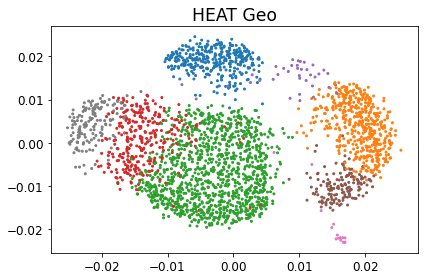

In [6]:
emb_op = EmbHeatGeo(knn=knn)
emb_op.scatterplot(data,labels,title="HEAT Geo", tau=10)

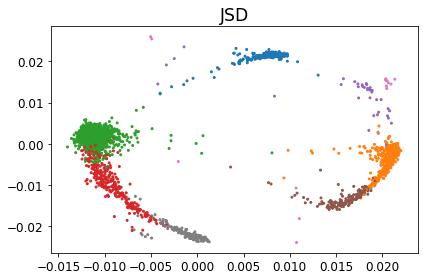

In [7]:
emb_op = EmbJSD(knn=knn)
emb_op.scatterplot(data,labels,title="JSD", tau=10)

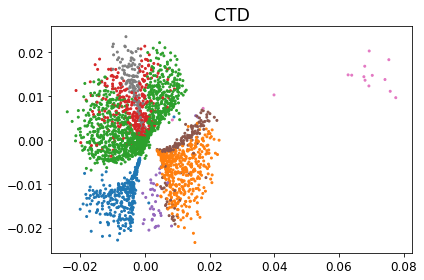

In [8]:
emb_op = EmbCTD(knn=knn)
emb_op.scatterplot(data,labels,title="CTD")

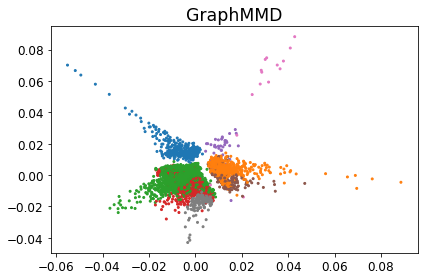

In [9]:
emb_op = EmbGraphMMD(knn=knn)
emb_op.scatterplot(data,labels,title="GraphMMD")

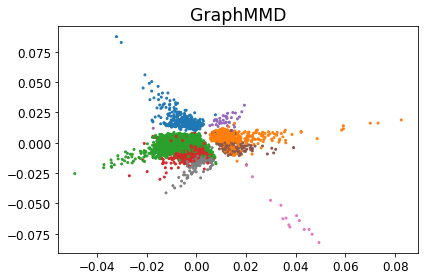

In [10]:
emb_op = EmbGraphMMD(knn=knn)
emb_op.scatterplot(data,labels,title="GraphMMD", T=10)